# GNN Training Diagnostics

Visualise loss curves and validation metrics recorded during training. Re-run the training pipeline with the updated logging to populate the history files.

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

def _locate_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        candidate = candidate.resolve()
        if (candidate / 'src').exists():
            return candidate
    raise RuntimeError('Could not locate project root containing "src" directory')

PROJECT_ROOT = _locate_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

os.chdir(PROJECT_ROOT)

try:
    import seaborn as sns
    sns.set_theme(style='whitegrid')
except ImportError:  # pragma: no cover
    sns = None
    plt.style.use('ggplot')

from src.analysis.performance import load_training_history, load_step_losses

RUN_DIR = Path('outputs/gnn_runs/heterogeneous')
history_df = None
step_df = None
try:
    history_df = load_training_history(RUN_DIR)
except FileNotFoundError as exc:
    print(f'Training history not found: {exc}')
try:
    step_df = load_step_losses(RUN_DIR)
except FileNotFoundError as exc:
    print(f'Step-level losses not found: {exc}')

if history_df is not None and not history_df.empty:
    display(history_df.head())
else:
    print('Run training to generate history metrics.')
if step_df is not None and not step_df.empty:
    display(step_df.head())


,epoch,train_loss,val_weighted_score,val_dispatch_error,val_dispatch_error_mae,val_dispatch_error_rmse,val_dispatch_error_normalized_mae,val_cost_gap,val_cost_gap_mean_gap,val_cost_gap_median_gap,val_cost_gap_max_gap,val_violation_rate,val_violation_rate_mean_rate,val_violation_rate_max_rate,is_best
0,1,1754.780115,0.368263,11.727247,11.727247,32.225026,0.088039,-0.960939,-0.960939,-0.961842,0.969093,0.516781,0.516781,0.633290,True
1,2,1187.935345,0.374318,11.650936,11.650936,32.563329,0.086856,-0.958688,-0.958688,-0.959579,0.966941,0.531921,0.531921,0.652104,False
2,3,1035.041574,0.352584,11.337231,11.337231,31.507998,0.085235,-0.962799,-0.962799,-0.963700,0.970881,0.484330,0.484330,0.602041,True
3,4,929.680232,0.411355,13.014284,13.014284,34.419145,0.096237,-0.952238,-0.952238,-0.953099,0.960719,0.606278,0.606278,0.718269,False
4,5,861.937294,0.427736,13.572402,13.572402,35.439833,0.099857,-0.948995,-0.948995,-0.949762,0.957444,0.639780,0.639780,0.751222,False


,step,epoch,loss
0,25.0,1.0,9842.225049
1,50.0,1.0,5169.675693
2,75.0,1.0,3890.388145
3,100.0,1.0,4314.330483
4,125.0,1.0,3251.747988


## Epoch-level Metrics


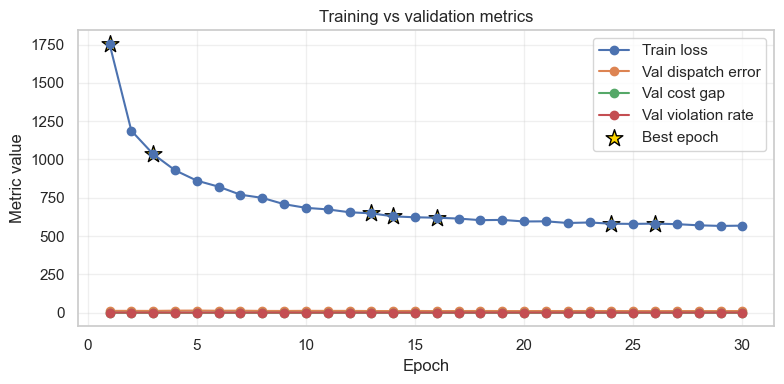

In [2]:
if history_df is not None and not history_df.empty:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(history_df['epoch'], history_df['train_loss'], marker='o', label='Train loss')
    for col, label in [('val_dispatch_error', 'Val dispatch error'),
                     ('val_cost_gap', 'Val cost gap'),
                     ('val_violation_rate', 'Val violation rate')]:
        if col in history_df:
            ax.plot(history_df['epoch'], history_df[col], marker='o', label=label)
    if 'is_best' in history_df:
        best = history_df[history_df['is_best']]
        if not best.empty:
            ax.scatter(best['epoch'], best['train_loss'], s=160, marker='*', color='gold', edgecolor='black', label='Best epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric value')
    ax.set_title('Training vs validation metrics')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
else:
    print('No epoch history to plot.')


## Step-level Loss


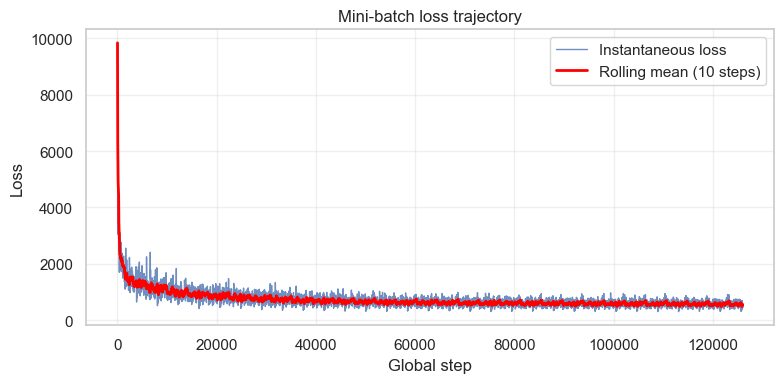

In [3]:
if step_df is not None and not step_df.empty:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(step_df['step'], step_df['loss'], linewidth=1, alpha=0.8, label='Instantaneous loss')
    if 'step' in step_df:
        rolling = step_df.set_index('step')['loss'].rolling(window=10, min_periods=1).mean()
        ax.plot(rolling.index, rolling.values, color='red', linewidth=2, label='Rolling mean (10 steps)')
    ax.set_xlabel('Global step')
    ax.set_ylabel('Loss')
    ax.set_title('Mini-batch loss trajectory')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
else:
    print('No step-level loss data available.')
